In [21]:
from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline


# #############################################################################
# load it as numpy arrays

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

Step 1.
Download the dataset

Download the data

Find the number of samples, number of features, number of classes

In [39]:
n_samples, h, w = lfw_people.images.shape

X = lfw_people.data
n_features = X.shape[1]

y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


### Step 2. Train the Model
- Split the data into test and train datasets
- Compute a PCA (eigenfaces) on the face dataset
- Train an SVM Model
- Create a confusion matrix to evaluate the model.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

In [24]:
pca = PCA(n_components=.95, whiten=True, random_state=42)
svc = SVC(kernel='rbf',class_weight='balanced')
model = make_pipeline(pca,svc)

In [25]:
def eval_metric(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)

    print("Test_Set")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print()
    print("Train_Set")
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))

In [26]:
svm_model = SVC(random_state=42)
svm_model.fit(X_train, y_train)
eval_metric(svm_model, X_train, y_train, X_test, y_test)

Test_Set
[[  6   4   1   2   0   0   0]
 [  0  50   1   9   0   0   0]
 [  0   2  14  11   0   0   0]
 [  0   4   0 142   0   0   0]
 [  0   0   0  11  11   0   3]
 [  0   2   0   7   1   5   0]
 [  0   2   0  15   0   0  19]]
              precision    recall  f1-score   support

           0       1.00      0.46      0.63        13
           1       0.78      0.83      0.81        60
           2       0.88      0.52      0.65        27
           3       0.72      0.97      0.83       146
           4       0.92      0.44      0.59        25
           5       1.00      0.33      0.50        15
           6       0.86      0.53      0.66        36

    accuracy                           0.77       322
   macro avg       0.88      0.58      0.67       322
weighted avg       0.80      0.77      0.75       322


Train_Set
[[ 58   4   0   2   0   0   0]
 [  0 166   0  10   0   0   0]
 [  0   1  82  11   0   0   0]
 [  0   0   0 384   0   0   0]
 [  0   1   0   6  73   0   4]
 [  0   0 

## **Different approach**

In [29]:
n_components = 150

print('Extracting the top %d eigenfaces from %d faces'
      % (n_components,X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
print('done in %0.3fs' % (time()-t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print('Projecting the input data on the eigenfaces orthonormal basis')
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print('done in %0.3fs' % (time()-t0))

Extracting the top 150 eigenfaces from 966 faces
done in 0.576s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.032s


In [30]:
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3,5e3,1e4,5e4,1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print('done in %0.3fs' % (time()-t0))
print('Best estimator found by grid search:')
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 21.485s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.005)


In [31]:
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time()-t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Predicting people's names on the test set
done in 0.066s
                   precision    recall  f1-score   support

     Ariel Sharon       0.88      0.54      0.67        13
     Colin Powell       0.82      0.88      0.85        60
  Donald Rumsfeld       0.82      0.67      0.73        27
    George W Bush       0.84      0.98      0.90       146
Gerhard Schroeder       0.95      0.80      0.87        25
      Hugo Chavez       0.86      0.40      0.55        15
       Tony Blair       1.00      0.78      0.88        36

         accuracy                           0.85       322
        macro avg       0.88      0.72      0.78       322
     weighted avg       0.86      0.85      0.85       322

[[  7   1   0   5   0   0   0]
 [  1  53   3   2   0   1   0]
 [  0   3  18   6   0   0   0]
 [  0   3   0 143   0   0   0]
 [  0   1   0   4  20   0   0]
 [  0   3   0   6   0   6   0]
 [  0   1   1   5   1   0  28]]


In [33]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

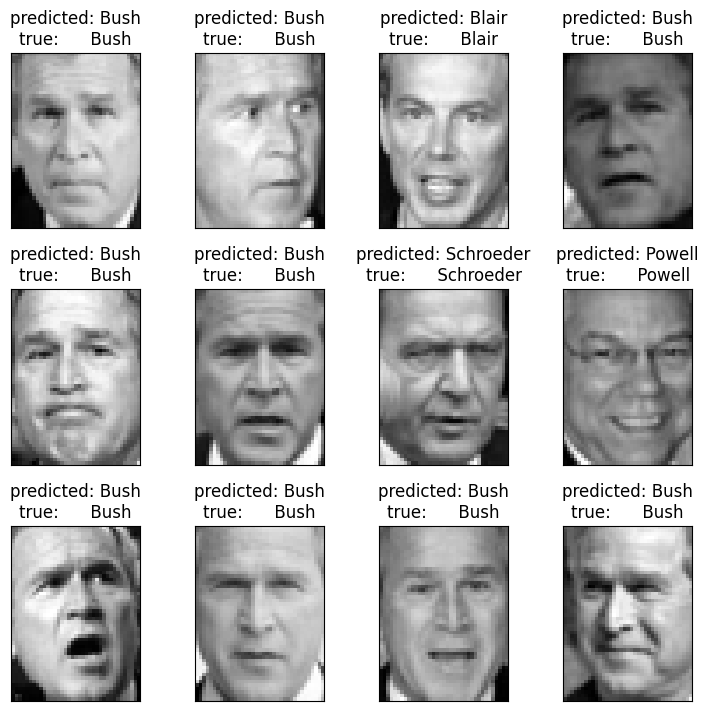

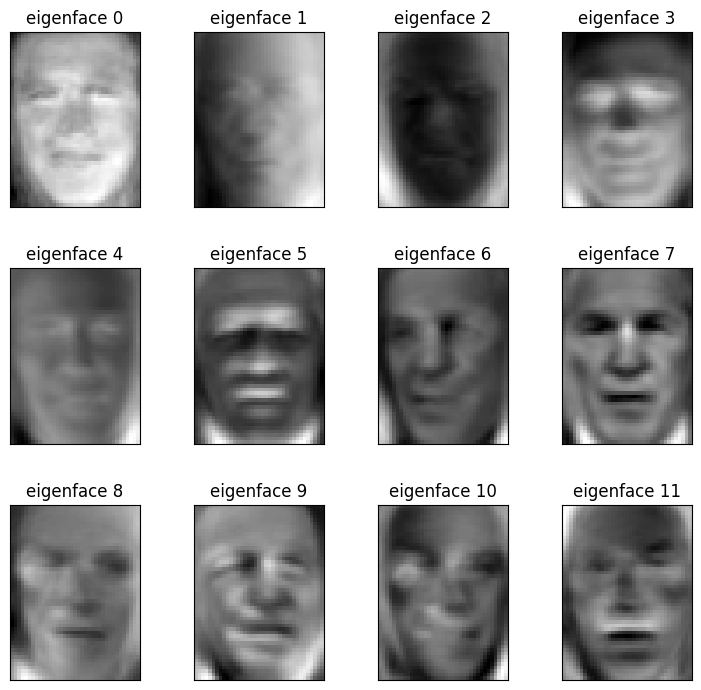

In [35]:
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()